# Reproduce the analysis in the paper

This notebook describes the steps necessary to analyze the experimental results and get the plots in the paper.
_To cut run time, the pre-computed results are in a dedicated folder: `src/utils.RESULTS_DIR`. The corresponding cells are commented out._

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns

from functools import reduce
from pathlib import Path
from tqdm.notebook import tqdm

import src.utils as u
import src.rank_metrics as rm
import src.rank_utils as ru

if Path(os.getcwd()).name != "EncoderBenchmarking":
    os.chdir("..")  # move kernel to EncoderBenchmarking

ModuleNotFoundError: No module named 'tqdm.notebok'

# Results loading

Load the results and the precomputed rankings, stored in the `src/utils.RESULTS_DIR` directory (default: `experimental_results`).

In [55]:
df = pd.read_parquet(u.RESULTS_DIR / "results.parquet")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61812 entries, 0 to 61811
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   dataset   61812 non-null  object 
 1   model     61812 non-null  object 
 2   scoring   61812 non-null  object 
 3   tuning    61812 non-null  object 
 4   encoder   61812 non-null  object 
 5   cv_score  61812 non-null  float64
dtypes: float64(1), object(5)
memory usage: 2.8+ MB


Compute the rankings

In [107]:
rf = ru.get_rankings(df, factors=["dataset", "model", "tuning", "scoring"], alternatives="encoder", target="cv_score",
                     increasing=True, impute_missing=False)
rf.to_parquet(u.RESULTS_DIR / "rankings.parquet")
rf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32 entries, BE to WOEE
Columns: 2036 entries, ('1037', 'DTC', 'full', 'ACC') to ('981', 'SVC', 'no', 'F1')
dtypes: float64(725), int64(1311)
memory usage: 510.3+ KB


## Sensitivity analysis
The relative performance of encoders can depend on an ML model, a quality metric, or a tuning strategy. The choice of an aggregation strategy impacts the consensus ranking.
To quantify the influence of these choices, we calculate the similarity between rankings using the Jaccard index $J$ for the sets of best encoders as well as the Spearman correlation coefficient $\rho$.
For both measures, values close to 1 indicate high agreement between rankings and low sensitivity. Conversely, values near 0 (or, for $\rho$, negative) suggest low consistency and high sensitivity.

### Sensitivity to experimental factors
We evaluate the sensitivity of encoder rankings on individual datasets with respect to an experimental factor (ML model, quality metric, or tuning strategy) by varying the factor of interest and keeping the other factors fixed, then calculating the similarity between pairs of rankings. After that, we average the result across all combinations of the other factors.
Our findings highlight the high sensitivity of results of studies comparing encoders to experimental factors, for both the full rankings and the best encoders.
They also explain why results from other studies are not comparable, as choosing different values for any factor will lead to different results.

In [56]:
%%time
jaccard_model, rho_model = u.pairwise_similarity_wide_format(rf, simfuncs=[rm.jaccard_best, rm.spearman_rho], shared_levels=[0, 2, 3])
jaccard_tuning, rho_tuning = u.pairwise_similarity_wide_format(rf, simfuncs=[rm.jaccard_best, rm.spearman_rho], shared_levels=[0, 1, 3])
jaccard_scoring, rho_scoring = u.pairwise_similarity_wide_format(rf, simfuncs=[rm.jaccard_best, rm.spearman_rho], shared_levels=[0, 1, 2])

jaccard = reduce(lambda x, y: x.fillna(y), [jaccard_model, jaccard_tuning, jaccard_scoring])
rho = reduce(lambda x, y: x.fillna(y), [rho_model, rho_tuning, rho_scoring])

jaccard.to_parquet(u.ANALYSIS_DIR / "pw_jaccard.parquet")
rho.to_parquet(u.ANALYSIS_DIR / "pw_rho.parquet")

CPU times: total: 3min 7s
Wall time: 3min 8s


Plot the sensitivity of results to experimental factors.

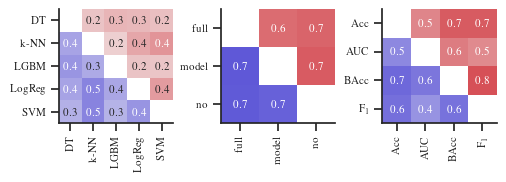

In [60]:
sims = u.load_similarity_dataframes()
rho = sims["pw_rho"]
jaccard = sims["pw_jaccard"]

factors = ["model", "tuning", "scoring"]
similarities = ["rho", "jaccard"]

sns.set(font_scale=0.8)
sns.set_style("ticks")
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{mathptmx}'
mpl.rc('font', family='Times New Roman')

fig, axes = plt.subplots(1, len(factors), figsize=(5, 3))
for ax, factor in zip(axes, factors):
    df_sim = u.join_wide2long({"jaccard": jaccard, "rho": rho}, comparison_level=factor)
    title = factor
    u.heatmap_longformat_multisim(df_sim, similarities, factor, fontsize=8, annot_fontsize=8, ax=ax)

sns.despine()
plt.tight_layout(pad=0.5)
fig.savefig(u.FIGURES_DIR / "heatmap_model_tuning_scoring.pdf")
plt.show()

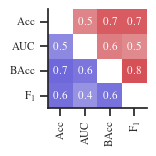

In [64]:
# TEMPORARY

# del u
# import src.utils as u

# u.ANALYSIS_DIR = u.BASE_DIR / "analysis" / "analysis_results_SAVE"
sims = u.load_similarity_dataframes()
rho = sims["pw_rho"]
jaccard = sims["pw_jaccard"]

factor = "scoring"

fig, ax = plt.subplots(1, 1, figsize=(1.5, 1.5))
df_sim = u.join_wide2long({"jaccard": jaccard, "rho": rho}, comparison_level=factor)
df_sim.scoring_1 = df_sim[f"{factor}_1"]
df_sim.scoring_2 = df_sim[f"{factor}_2"]
u.heatmap_longformat_multisim(df_sim, similarities, factor, fontsize=8, annot_fontsize=8, ax=ax)

sns.despine()
plt.tight_layout(pad=0.5)
fig.savefig(u.FIGURES_DIR / f"heatmap_{factor}_TMP.pdf")
plt.show()

### Sensitivity to aggregation strategy

To evaluate the impact of the aggregation strategy on the consensus ranking, we apply the same procedure as above to consensus rankings instead of rankings on individual datasets.
For example, Spearman's $\rho$ between consensus rankings obtained with Q-M and Q-Md averaged across all ML models, tuning strategies, and quality metrics is 0.8.

While some aggregation strategies show strong similarities, different strategies yield very different consensus rankings in general.
This is particularly evident for Jaccard index $J$, indicating the high sensitivity of the best encoders to the rank aggregation strategy.

We begin by computing the consensus rankings with different aggregation strategies.

In [111]:
%%time
from importlib import reload

reload(ru)

consensuses = list()

# --- Aggregation for all aggregation strategies except Nemenyi
consensuses.append(ru.Aggregator(df, rf).aggregate(verbose=False, ignore_strategies=["nemenyi rank"]).aggrf)

# --- Aggregation with Nemenyi with different significance levels
for alpha in tqdm([0.01, 0.05, 0.1]):
    agg = ru.Aggregator(df, rf)
    bag = agg.base_aggregators[('SVC', 'full', 'AUC')]
    consensuses.append(agg.aggregate(verbose=False, strategies=["nemenyi rank"], alpha=alpha).aggrf)

aggrf = pd.concat(consensuses, axis=1)
aggrf.to_parquet(u.ANALYSIS_DIR / "consensuses.parquet")

C:\Users\federicom\Documents\GitHub\EncoderBenchmarking\src\rank_utils.py:284: RuntimeWarning: invalid value encountered in true_divide
  """
C:\Users\federicom\Documents\GitHub\EncoderBenchmarking\src\rank_utils.py:284: RuntimeWarning: invalid value encountered in true_divide
  """
C:\Users\federicom\Documents\GitHub\EncoderBenchmarking\src\rank_utils.py:284: RuntimeWarning: invalid value encountered in true_divide
  """


NameError: name 'tqdm' is not defined

In [121]:
c1= pd.read_parquet(u.ANALYSIS_DIR / "consensuses_nem.parquet")
c2 = pd.read_parquet(u.ANALYSIS_DIR / "consensuses_no_nem.parquet")

aggrf = pd.concat([c1, c2], axis=1)
aggrf.to_parquet(u.ANALYSIS_DIR / "consensuses.parquet")

We then compute the similarity between different consensuses ...

In [122]:
aggrf = u.load_aggrf().rename(columns=u.AGGREGATION_NAMES, level="aggregation")
agg_jaccard, agg_rho = u.pairwise_similarity_wide_format(aggrf, simfuncs=[rm.jaccard_best, rm.spearman_rho], shared_levels=slice(-1))

agg_jaccard.to_parquet(u.ANALYSIS_DIR / "pw_AGG_jaccard.parquet")
agg_rho.to_parquet(u.ANALYSIS_DIR / "pw_AGG_rho.parquet")

... and finally plot it.

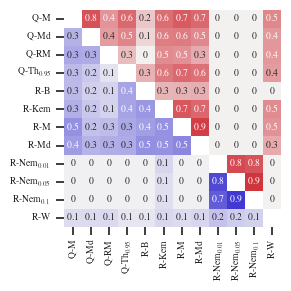

In [125]:
aggsims = u.load_aggregated_similarity_dataframes()
agg_jaccard = aggsims["pw_AGG_jaccard"]
agg_rho = aggsims["pw_AGG_rho"]

df_sim = u.join_wide2long({"rho": agg_rho, "jaccard": agg_jaccard}, comparison_level="aggregation")

sns.set_style("ticks")
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{mathptmx}'
mpl.rc('font', family='Times New Roman')

fig, ax = plt.subplots(1, 1, figsize=(3, 3.3))
u.heatmap_longformat_multisim(df_sim, ["rho", "jaccard"], "aggregation", fontsize=7, annot_fontsize=7, ax=ax)
plt.tight_layout()

fig.savefig(u.FIGURES_DIR / f"heatmap_aggregation.pdf")
plt.show()

## Replicability

Replicability is the property of a benchmark of obtaining consistent results from different data. We quantify replicability by comparing consensus rankings aggregated on two disjoint samples of datasets of equal size.
Each data point represents 100 iterations of randomly selecting two disjoint sets of datasets and applying multiple aggregation strategies. We exclude R-Kem due to its high computational complexity.
Even with 25 datasets, replicability is moderate: this suggests that consensus rankings vary significantly depending on the data.
Results from logistic regression tend to exhibit the highest replicability among ML models, while decision trees show the lowest.

The next cells perform the replicability analysis and plot the results.

In [301]:
df = pd.read_parquet(u.RESULTS_DIR / "results.parquet")
rf = pd.read_parquet(u.RESULTS_DIR / "rankings.parquet")
reload(ru)
for tuning in ["no", "model" "full"]:
    a = ru.replicability_analysis(df, rf, tuning, sample_sizes=[5, 10, 15, 20, 25], repetitions=100, seed=1444, append_to_existing=False, save=True, ignore_strategies=["nemenyi rank", "kemeny rank"])

  0%|          | 0/5 [00:00<?, ?it/s]

In [309]:
sample_df_sim = pd.concat([pd.read_parquet(u.ANALYSIS_DIR / f"sample_sim_{tuning}.parquet") for tuning in ("no", "model", "full")], axis=0)
sample_df_sim

,model,tuning,scoring,aggregation,sample_1,sample_2,jaccard,rho,sample_size,jaccard_std,rho_std
1,DTC,no,ACC,QM,"{'43897', '1037', '1511', '38', '334'}","{'881', '470', '1463', '41162', '41224'}",0.000000,0.510084,5,0.294784,0.275717
4,DTC,no,ACC,QMd,"{'43897', '1037', '1511', '38', '334'}","{'881', '470', '1463', '41162', '41224'}",0.000000,-0.129678,5,0.264868,0.263113
7,DTC,no,ACC,QR,"{'43897', '1037', '1511', '38', '334'}","{'881', '470', '1463', '41162', '41224'}",0.000000,0.430510,5,0.253167,0.264996
10,DTC,no,ACC,QT95,"{'43897', '1037', '1511', '38', '334'}","{'881', '470', '1463', '41162', '41224'}",0.000000,0.004528,5,0.175502,0.262620
13,DTC,no,ACC,RM,"{'43897', '1037', '1511', '38', '334'}","{'881', '470', '1463', '41162', '41224'}",0.000000,0.467450,5,0.255231,0.298541
...,...,...,...,...,...,...,...,...,...,...,...
394,SVC,full,F1,QT95,"{'333', '1506', '1590', '6332', '29', '1511', ...","{'43897', '3', '1037', '43896', '23381', '4099...",0.000000,0.575326,15,0.225408,0.199536
397,SVC,full,F1,RM,"{'333', '1506', '1590', '6332', '29', '1511', ...","{'43897', '3', '1037', '43896', '23381', '4099...",0.000000,0.620747,15,0.407830,0.211898
400,SVC,full,F1,RMd,"{'333', '1506', '1590', '6332', '29', '1511', ...","{'43897', '3', '1037', '43896', '23381', '4099...",0.000000,0.671395,15,0.393802,0.226816
403,SVC,full,F1,RB,"{'333', '1506', '1590', '6332', '29', '1511', ...","{'43897', '3', '1037', '43896', '23381', '4099...",0.333333,0.432631,15,0.325769,0.204603


We now plot the replicability conditional on either model, scoring, or aggregation.

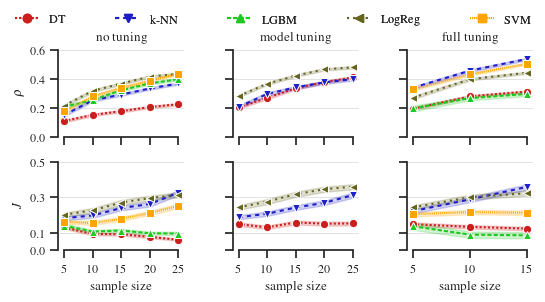

In [339]:
factor = "model"
fig = u.lineplot_replicability(sample_df_sim, hue=factor, show=True)

fig.savefig(u.FIGURES_DIR / f"lineplot_replicability_{factor}.pdf")
plt.show()

## Comparing encoders
We now examine the ranks of encoders limited to decision trees, logistic regression, and all ML models.

The left subplot shows the rank of encoders from the experiments with decision trees across all datasets, quality metrics, and tuning strategies.
One-Hot is the best-performing encoder; however, Nemenyi tests at a significance level of 0.05 fail to reject that the average rank of One-Hot is the same as that of the other encoders.

The central subplot features the encoder ranks for logistic regression, where four encoders, namely One-Hot, Sum, Binary, and Weight of Evidence, consistently achieve higher ranks compared to the others.
Nemenyi tests confirm that this difference in ranks is significant.
These results indicate low replicability of the results for decision trees and higher replicability for logistic regression.

The right plot presents the ranks of encoders across all datasets, ML models, quality metrics, and tuning strategies.
Similarly to logistic regression, One-Hot, Sum, Binary, and Weight of Evidence consistently achieve significantly higher average ranks compared to the other encoders, again confirmed by Nemenyi tests.
We recommend these four encoders as the preferred choices in practical applications.
This conclusion contradicts other studies reporting a suboptimal performance of One-Hot~\cite{cerda_similarity_2018, pargent_regularized_2022}.

Our findings also reveal that Drop performs significantly worse than all other encoders, i.e., encoding categorical attributes generally yields better results than dropping them.

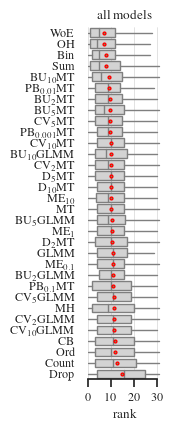

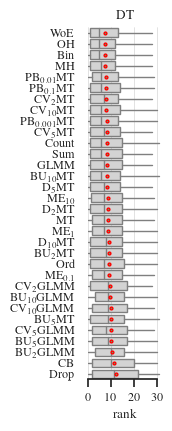

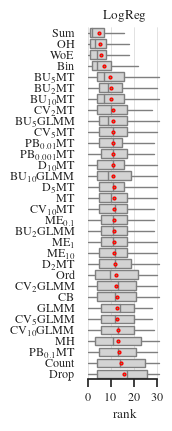

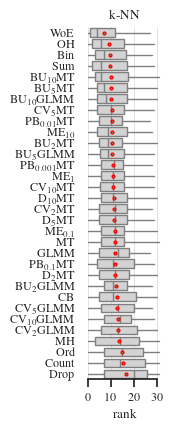

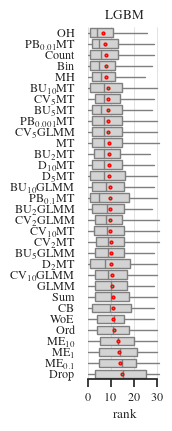

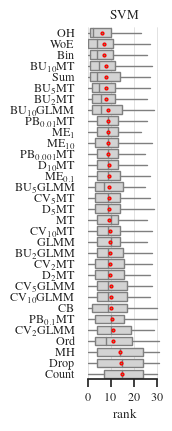

In [355]:
rf = pd.read_parquet(u.RESULTS_DIR / "rankings.parquet")
models = [None, "DTC", "LR", "KNC", "LGBMC", "SVC"]

sns.set(font_scale=0.8)
sns.set_style("ticks", {"ytick.left": False})
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{mathptmx}'
mpl.rc('font', family='Times New Roman')

for model in models:
    fig, ax = plt.subplots(1, 1, figsize=(1.8, 4.4))
    u.boxplot_encoder_ranks(rf, ax, model)
    if model is None:
        ax.set_title("all models")
    else:
        ax.set_title(u.FACTOR_LATEX["model"][model])
    ax.set_xlabel("rank")
    sns.despine(left=True, trim=True)
    plt.tight_layout(w_pad=0.5)

    fig.savefig(u.FIGURES_DIR / f"boxplot_rank_{model}.pdf")

## Missing evaluations

The following cell computes the number of missing evaluations.

In [351]:
import numpy as np
import src.config as cfg

from itertools import product


total_runs = {}
for tuning_strategy in ["no tuning", "model tuning", "full tuning"]:
    total_runs[tuning_strategy] = product(cfg.ENCODERS,
                                          cfg.DATASET_IDS[tuning_strategy],
                                          cfg.MODELS[tuning_strategy],
                                          cfg.SCORINGS)
num_runs = sum(len(list(x)) for x in total_runs.values())

print(f"Total runs     : {num_runs}")
print(f"Completed runs : {len(df)}")

Total runs     : 64000
Completed runs : 61812


## Runtime

The following cells studies the runtime of encoders.

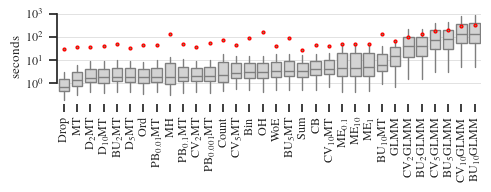

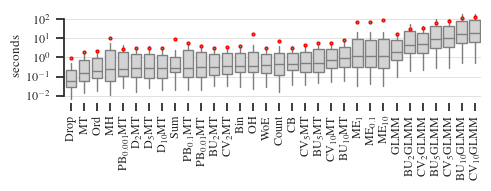

In [200]:
reload(u)
df = pd.read_parquet(u.RESULTS_DIR / "results.parquet")
df_ = df.copy()
df_["encoder"] = df_["encoder"].map(u.ENCODER_LATEX)

fig, ax = plt.subplots(1, 1, figsize=(5, 2))
ax = u.boxplot_runtime(df_.query("tuning == 'full'"), ax=ax)
sns.despine(bottom=True, trim=True)
plt.tight_layout(w_pad=0.5)
fig.savefig(u.FIGURES_DIR / "boxplot_tuning_time.pdf")

fig, ax = plt.subplots(1, 1, figsize=(5, 2))
ax = u.boxplot_runtime(df_.query("tuning != 'full'"), ax=ax)
sns.despine(bottom=True, trim=True)
plt.tight_layout(w_pad=0.5)
fig.savefig(u.FIGURES_DIR / "boxplot_encoding_time.pdf")

plt.show()

## Tuning

This cell investigates if tuning lead to an increase in pipeline performance wrt. no tuning.

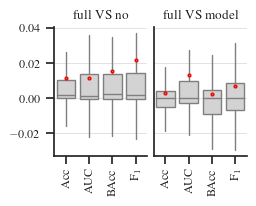

In [428]:
df = pd.read_parquet(u.RESULTS_DIR / "results.parquet")
df_ = u.get_dataset_tuning_comparison(df)

sns.set(font_scale=0.8)
sns.set_style("ticks")
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{mathptmx}'
mpl.rc('font', family='Times New Roman')

factor = "scoring"
df_[factor] = df_[factor].map(u.FACTOR_LATEX[factor])
fig, axes = plt.subplots(1, len(factors), figsize=(2.5, 2), sharey="all")
for it, ((tuning_x, tuning_y), ax) in enumerate(zip([("full", "no"), ("full", "model")], axes)):
    ax = sns.boxplot(data=df_.query("tuning_x == @tuning_x and tuning_y == @tuning_y"), x=factor, y="gain",
                                 # palette=sns.light_palette("grey", n_colors=len(rf.index)),
                                 color="lightgrey",
                                 showfliers=False,
                                 linewidth=1, showcaps=False,
                                 showmeans=True,
                                 meanprops={"marker": "o",
                                            "markeredgecolor": "red",
                                            "markersize": 2},
                                 medianprops={"linestyle": "-"
                                              },
                                 ax=ax)
    ax.grid(axis="y", zorder=-1, linewidth=0.4)

    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=90,
    )

    if it != 0:
        ax.tick_params(left=False)

    ax.set_title(f"{tuning_x} VS {tuning_y}")

sns.despine()
plt.tight_layout(pad=0.5)

plt.savefig(u.FIGURES_DIR / f"boxplot_tuningeffect_{factor}.pdf")

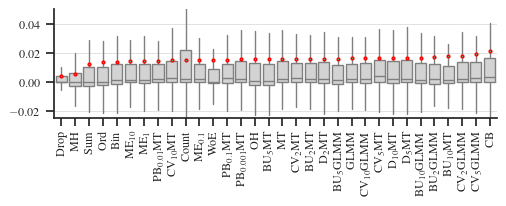

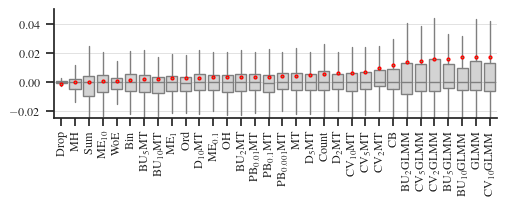

In [435]:
df = pd.read_parquet(u.RESULTS_DIR / "results.parquet")
df_ = u.get_dataset_tuning_comparison(df)

sns.set(font_scale=0.8)
sns.set_style("ticks")
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{mathptmx}'
mpl.rc('font', family='Times New Roman')

df_["encoder"] = df_["encoder"].map(u.ENCODER_LATEX)
for tuning_x, tuning_y in [("full", "no"), ("full", "model")]:
    fig, ax = plt.subplots(1, 1, figsize=(5, 2))
    ax = u.sorted_boxplot_vertical(data=df_.query("tuning_x == @tuning_x and tuning_y == @tuning_y"), x="encoder", y="gain", order_by="mean",
                                 # palette=sns.light_palette("grey", n_colors=len(rf.index)),
                                 color="lightgrey",
                                 showfliers=False,
                                 linewidth=1, showcaps=False,
                                 showmeans=True,
                                 meanprops={"marker": "o",
                                            "markeredgecolor": "red",
                                            "markersize": 2},
                                 medianprops={"linestyle": "-"
                                              },
                                 ax=ax)
    ax.grid(axis="y", zorder=-1, linewidth=0.4)

    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=90,
    )

    ax.set_ylim([-0.025, 0.050])

    # ax.set_title(f"{tuning_x} VS {tuning_y}")

    sns.despine()
    plt.tight_layout(pad=0.5)

    plt.savefig(u.FIGURES_DIR / f"boxplot_tuningeffect_encoder_{tuning_x}_{tuning_y}.pdf")

In [427]:
df_

,dataset,model,scoring,tuning_x,encoder,cv_score_x,time_x,tuning_y,cv_score_y,time_y,gain
0,3,DTC,ACC,full,NaN,0.908341,5.305030,no,0.908341,0.961320,0.000000
1,3,DTC,ACC,full,NaN,0.908341,289.415915,no,0.908341,29.473675,0.000000
2,3,DTC,ACC,full,NaN,0.908341,17.787040,no,0.908341,1.338475,0.000000
3,3,DTC,ACC,full,NaN,0.908341,73.155539,no,0.908341,6.894378,0.000000
4,3,DTC,ACC,full,NaN,0.908341,3.579180,no,0.908341,0.362093,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
11279,43922,LR,F1,full,NaN,0.837584,2.864848,model,0.844432,0.320445,-0.006847
11280,43922,LR,F1,full,NaN,0.892371,19.098240,model,0.897758,3.647450,-0.005387
11281,43922,LR,F1,full,NaN,0.950983,4.910950,model,0.930823,0.269488,0.020159
11282,43922,LR,F1,full,NaN,0.893827,2.531251,model,0.899513,0.629985,-0.005686
